In [71]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import numpy as np
import open3d as o3d

from open3D_tools import create_open3D_frame,create_open3D_point,create_open3d_ray, create_open3D_camera

In [73]:
f_x = 1000
f_y = 1000

W = 1920
H = 1080

c_x = W/2
c_y = H/2

K = np.array([[f_x, 0, c_x],[0, f_y, c_y],[0, 0, 1]])


In [74]:
def project_point(K, camera_pose, point):
    # create homogeneous point 
    point = np.hstack([point, 1])   
    point_in_camera_coords = np.linalg.inv(camera_pose) @ point.T
    pixels = K @ point_in_camera_coords[:3]
    pixels /= pixels[2]
    return pixels[:2]

def ray_from_pixels(K, pixels):
    pixels = np.hstack([pixels, 1])
    ray = np.linalg.inv(K) @ pixels
    ray /= np.linalg.norm(ray)
    return ray

In [75]:
def create_camera_pose(min_radius, max_radius, max_angle: float = np.pi*2):
    radius = np.random.uniform(min_radius, max_radius)
    theta = np.random.uniform(0, max_angle)  # limit cap
    phi = np.random.uniform(0, np.pi / 2)  # Spherical cap

    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    # Camera position
    position = np.array([x, y, z])
    # Look at the origin
    target = np.array([0, 0, 0])

    # Define the up vector
    target = np.random.uniform(-0.5, 0.5, size=3)
    up = np.array([0, 0, 1])

    # Create the camera pose
    # Create the orientation of the camera
    forward = (target - position) / np.linalg.norm(target - position)
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    up = np.cross(forward, right)

    # Create the camera pose matrix
    camera_pose = np.eye(4)
    camera_pose[:3, :3] = np.vstack([right, up, forward]).T
    camera_pose[:3, 3] = position

    return camera_pose



def sample_camera_poses(min_radius, max_radius,max_angle, num_samples):
    poses = []
    while len(poses) < num_samples:
        pose = create_camera_pose(min_radius, max_radius, max_angle=max_angle)


        projected_origin = project_point(K, pose, np.array([0, 0, 0]))
        # check origin is in camera frustum
        if projected_origin[0] > 0 and projected_origin[0] < W and projected_origin[1] > 0 and projected_origin[1] < H:
            pass
        else:
            continue
        
        poses.append(pose)

    return poses

# Example usage
min_radius = 0.3
max_radius = 2
num_samples = 4
camera_poses = sample_camera_poses(min_radius, max_radius,np.pi, num_samples)


In [76]:
# for each camera pose, project the origin 

projected_origins = []
for pose in camera_poses:
    projected_origin = project_point(K, pose, np.array([0, 0, 0]))
    projected_origins.append(projected_origin)



In [77]:
# visualize camera poses
open_3d_elements = []
for pixels, pose in zip(projected_origins, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)


o3d.visualization.draw_geometries(open_3d_elements)

In [78]:
sigma = 5
# add gaussian noise to the pixel locations 
noisy_pixels = []
for pixels in projected_origins:
    noisy_pixels.append(pixels + np.random.normal(0, sigma, size=2))
    print(f"pixel = {pixels}, noisy pixel = {noisy_pixels[-1]}")




pixel = [1057.27104742  629.16933668], noisy pixel = [1054.05996209  632.51596144]
pixel = [986.04001681 226.88188144], noisy pixel = [986.01362176 224.91079754]
pixel = [948.61311242 448.16369028], noisy pixel = [948.13640274 449.05545786]
pixel = [1191.10221841  630.02372913], noisy pixel = [1191.504606    624.95965214]


In [79]:
# visualize noisy rays
open_3d_elements = []
for pixels, pose in zip(noisy_pixels, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)
    
o3d.visualization.draw_geometries(open_3d_elements)



In [80]:
def multiview_midpoint_triangulation(pixel_coordinates,camera_poses, K):
    lhs = np.zeros((3,3))
    rhs = np.zeros(3)
    for pixel, pose in zip(pixel_coordinates, camera_poses):
        ray_in_camera = ray_from_pixels(K, pixel)
        ray_in_world = pose[:3,:3] @ ray_in_camera
        ray_in_world /= np.linalg.norm(ray_in_world)
        ray_in_world = ray_in_world.reshape(3,1)

        lhs += (np.eye(3) - ray_in_world @ ray_in_world.T)
        rhs += (np.eye(3) - ray_in_world @ ray_in_world.T) @ pose[:3,3]

    return np.linalg.inv(lhs) @ rhs

In [81]:
mvmp_point = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)
print(f"multiview midpoint triangulation = {mvmp_point}")

multiview midpoint triangulation = [-0.00040586  0.00082375  0.00079228]


In [82]:
# visualize the triangulated point and all rays and cameras

open_3d_elements = []
for pixels, pose in zip(noisy_pixels, camera_poses):
    camera = create_open3D_camera(pose,K)
    open_3d_elements.extend(camera)
    ray = ray_from_pixels(K, pixels)
    ray = pose[:3,:3] @ ray
    ray = create_open3d_ray(ray,pose[:3,3])
    open_3d_elements.append(ray)

point = create_open3D_point(mvmp_point)
open_3d_elements.append(point)

o3d.visualization.draw_geometries(open_3d_elements)

In [83]:
def DLT_triangulation(pixel_coordinates,camera_poses, K):
    A = np.zeros((2*len(pixel_coordinates), 4))
    for i, (pixel, pose) in enumerate(zip(pixel_coordinates, camera_poses)):
        M = K @ np.linalg.inv(pose)[:3,:]
        u,v = pixel
        A[2*i] = u * M[2] - M[0]
        A[2*i+1] = v * M[2] - M[1]


    u, s, vh = np.linalg.svd(A)
    point = vh[-1]
    point /= point[3]
    return point[:3]


In [84]:
point = DLT_triangulation(noisy_pixels, camera_poses, K)

print(point)

[-0.0003387   0.00067215  0.00070882]


In [85]:
import torch 

# optimize the triangulation using pytorch on the reprojection error
def reprojection_error_torch(pixel, pose, point, K):
    pose = torch.linalg.inv(pose)
    projected_point = K @ (pose[:3,:3] @ point + pose[:3,3])
    projected_point =  projected_point[:2] / projected_point[2]
    error = torch.linalg.norm(pixel - projected_point, ord=2)
    return error

def reprojection_errors_torch(pixels, camera_poses, point, K):
    avg_error = torch.tensor(0.0)
    for pixel, pose in zip(pixels, camera_poses):
        error = reprojection_error_torch(pixel, pose, point, K)
        avg_error += error
    return avg_error / len(pixels)

def loss_function_torch(point, pixel_coordinates, camera_poses, K):
    return reprojection_errors_torch(pixel_coordinates, camera_poses, point, K)

def bundle_adjustment_triangulation_torch(pixel_coordinates,camera_poses, K):

    initial_guess = multiview_midpoint_triangulation(pixel_coordinates, camera_poses, K)
    best_guess = torch.tensor(initial_guess, requires_grad=True)
    K = torch.tensor(K)
    camera_poses = [torch.tensor(pose) for pose in camera_poses]
    pixel_coordinates = [torch.tensor(pixel) for pixel in pixel_coordinates]


    optimizer = torch.optim.Adam([best_guess], lr=0.0001)

    for i in range(50):
        optimizer.zero_grad()
        loss = loss_function_torch(best_guess, pixel_coordinates, camera_poses, K)
        if i % 10 == 0:
            # print(f"{i} - loss = {loss}")
            pass
        
        loss.backward()
        # print gradients for each variable
        optimizer.step()
    return best_guess.detach().numpy()



In [86]:
point = bundle_adjustment_triangulation_torch(noisy_pixels, camera_poses, K)

print(point)

[-0.00020452 -0.00118365  0.00055497]


In [87]:

n_cameras = [2,3,4,5]
min_radius = 0.3
max_radius = 2
num_samples = 1000

sigmas = [0, 1, 5, 10]
experiment_dicts = []
for n_camera in n_cameras:
    print(f"n_camera = {n_camera}")
    for sigma in sigmas:
        print(f"sigma = {sigma}")
        for i in range(num_samples):
            camera_poses = sample_camera_poses(min_radius, max_radius,np.pi, n_camera)

            pixels = []
            for pose in camera_poses:
                pixels.append(project_point(K, pose, np.array([0, 0, 0])))
            
            noisy_pixels = []
            for pixels in pixels:
                noisy_pixels.append(pixels + np.random.normal(0, sigma, size=2))

            mvmp_point = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(mvmp_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "mvmp"})
            
            dlt_point  = DLT_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(dlt_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "dlt"})

            bundle_point = bundle_adjustment_triangulation_torch(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(bundle_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "bundle"})
            




n_camera = 2
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 3
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 4
sigma = 0
sigma = 1
sigma = 5
sigma = 10
n_camera = 5
sigma = 0
sigma = 1
sigma = 5
sigma = 10


In [88]:
import pandas as pd
df = pd.DataFrame(experiment_dicts)

# average error for each method, sigma and number of cameras


# scale error to have it in mm
df
df["error"] = df["error"] * 1000


Text(0.5, 1.0, 'Comparison of different triangulation methods')

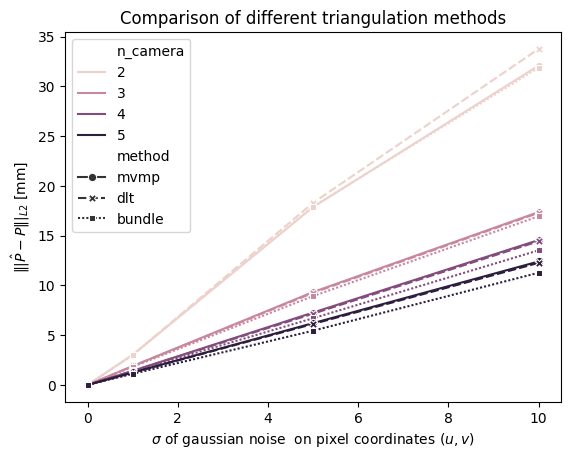

In [89]:
# plot multiline with sigma on x axis and different lines for n_camera
import seaborn as sns
import matplotlib.pyplot as plt

# add dots on the line
# stddev  on each dot
sns.lineplot(data=df, x="sigma", y="error", hue="n_camera", style="method", markers=True,errorbar=None)
plt.xlabel("$\sigma$ of gaussian noise  on pixel coordinates $(u,v)$")
plt.ylabel("$ \||\hat{P} - P\||_{L2}$ [mm]")
plt.title("""Comparison of different triangulation methods""")




In [90]:
# experiment with 2 cameras, get error for distance between two camera_poses


n_cameras = [2]
min_radius = 0.3
max_radius = 2
num_samples = 1000
sigmas = [0, 1, 5, 10]

experiment_dicts = []

for n_camera in n_cameras:
    print(f"n_camera = {n_camera}")
    for sigma in sigmas:
        print(f"sigma = {sigma}")
        for i in range(num_samples):
            camera_poses = sample_camera_poses(min_radius, max_radius,np.pi, n_camera)

            # get error for distance between two camera poses
            camera_distance = np.linalg.norm(camera_poses[0][:3,3] - camera_poses[1][:3,3])
            pixels = []
            for pose in camera_poses:
                pixels.append(project_point(K, pose, np.array([0, 0, 0])))
            
            noisy_pixels = []
            for pixels in pixels:
                noisy_pixels.append(pixels + np.random.normal(0, sigma, size=2))

            mvmp_point = multiview_midpoint_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(mvmp_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "mvmp", "camera_distance":camera_distance})
            
            dlt_point  = DLT_triangulation(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(dlt_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "dlt", "camera_distance":camera_distance})

            bundle_point = bundle_adjustment_triangulation_torch(noisy_pixels, camera_poses, K)
            error = np.linalg.norm(bundle_point - np.array([0,0,0]))
            experiment_dicts.append({"n_camera":n_camera, "sigma":sigma, "error":error, "method" : "bundle", "camera_distance":camera_distance})
            



n_camera = 2
sigma = 0
sigma = 1
sigma = 5
sigma = 10


Text(0.5, 0, 'distance between two cameras [rad]')

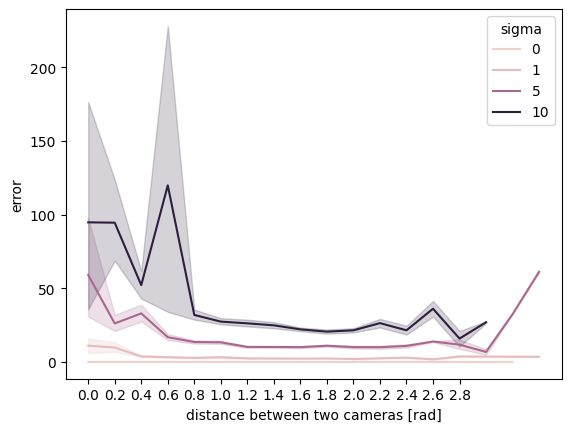

In [91]:
# plot error as function of sigma and camera distances
# split by different sigmas
# df = pd.DataFrame(experiment_dicts)
# df["error"] = df["error"] * 1000
# # group camera distances per 0.2
# df["camera_distance_binned"] = df["camera_distance"].apply(lambda x: int(x/0.2))
# sns.barplot(data=df, x="camera_distance_binned", y="error", hue="method")
# plt.xticks(labels=[f"{x*0.2:.2f}" for x in range(15)], ticks=range(15))
# plt.xlabel("distance between two cameras [rad]")
# plt.ylabel("$ \||\hat{P} - P\||_{L2}$ [mm]")
# plt.show()


# plot error as function of sigma and camera distances
# split by different sigmas
df = pd.DataFrame(experiment_dicts)
df["error"] = df["error"] * 1000
# group camera distances per 0.2
df["camera_distance_binned"] = df["camera_distance"].apply(lambda x: int(x/0.2))
sns.lineplot(data=df, x="camera_distance_binned", y="error", hue="sigma", markers=True)
plt.xticks(labels=[f"{x*0.2:.1f}" for x in range(15)], ticks=range(15))
plt.xlabel("distance between two cameras [rad]")



<Axes: xlabel='camera_distance', ylabel='error'>

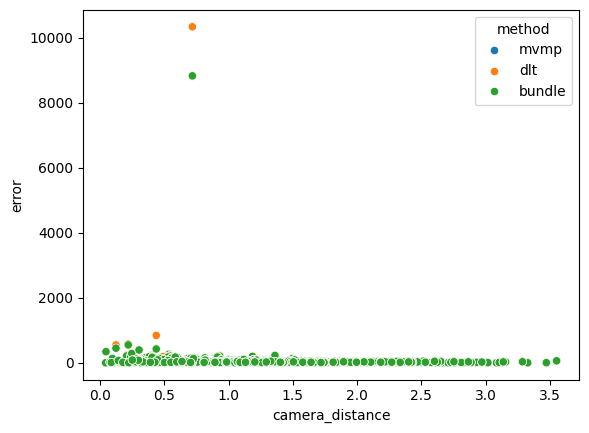

In [92]:
sns.scatterplot(data=df, x="camera_distance", y="error", hue="method")